## Lime Analysis of ConvNext-Tiny on ASD Dataset

In [1]:
!pip install lime

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import glob
from lime import lime_image
from skimage.segmentation import mark_boundaries
import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
DATA_PATH = "/kaggle/input/autism-image-data/AutismDataset"
MODEL_PATH = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_convnext_tiny_autism.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_PATH = "/kaggle/working"

In [4]:
# Configure explicit test image subset
TEST_PATH = os.path.join(DATA_PATH,  "test")  # adjust if path differs

# Target filenames (exact matches expected in test directory)
TARGET_FILES = [
    "Autistic.112.jpg",
    "Autistic.30.jpg",
    "Autistic.81.jpg",
    "Non_Autistic.74.jpg",
    "Non_Autistic.63.jpg",
    "Non_Autistic.55.jpg",
]

# Resolve existing files
selected_image_paths = []
missing = []
for fname in TARGET_FILES:
    candidate = os.path.join(TEST_PATH, fname)
    print(candidate)
    if os.path.exists(candidate):
        selected_image_paths.append(candidate)
    else:
        missing.append(fname)

print(f"Found {len(selected_image_paths)} target images. Missing: {len(missing)}")
if missing:
    print("Missing files:")
    for m in missing:
        print("  -", m)

selected_image_paths

/kaggle/input/autism-image-data/AutismDataset/test/Autistic.112.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Autistic.30.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Autistic.81.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.74.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.63.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.55.jpg
Found 6 target images. Missing: 0


['/kaggle/input/autism-image-data/AutismDataset/test/Autistic.112.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Autistic.30.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Autistic.81.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.74.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.63.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.55.jpg']

In [5]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])   

    return transform

def get_input_tensors(img):
    transform = get_input_transform()
    # unsqueeze converts single image to batch of 1
    return transform(img).unsqueeze(0)

In [6]:
def create_convnext_model(architecture='convnext_tiny', num_classes=2, pretrained=True):
    """Create ConvNeXt model for binary classification"""
    if architecture == 'convnext_tiny':
        model = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_small':
        model = timm.create_model('convnext_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_base':
        model = timm.create_model('convnext_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'convnext_tiny', 'convnext_small', or 'convnext_base'")
    
    return model

In [7]:
model = create_convnext_model(architecture='convnext_tiny', pretrained=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [8]:
# If your dataset labels were 0 = non-autistic, 1 = autistic
idx2label = ["non-autistic", "autistic"]
cls2idx = {"non-autistic": 0, "autistic": 1}
cls2label = {"non-autistic": "non-autistic", "autistic": "autistic"}

In [9]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [10]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(pill_transf(Image.fromarray(i))) for i in images), dim=0)
    batch = batch.to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

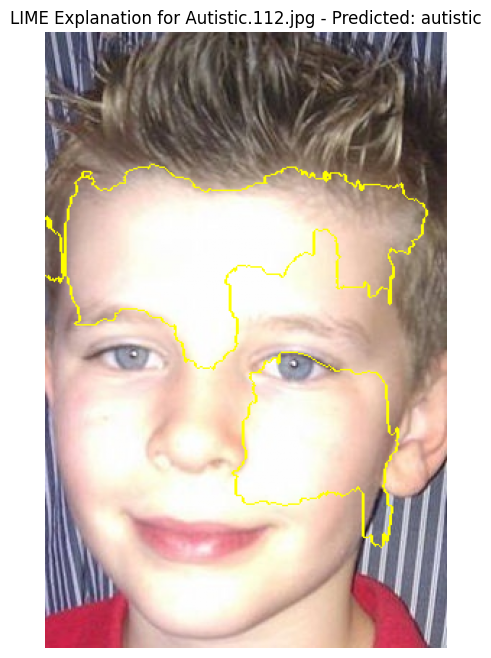

  0%|          | 0/1000 [00:00<?, ?it/s]

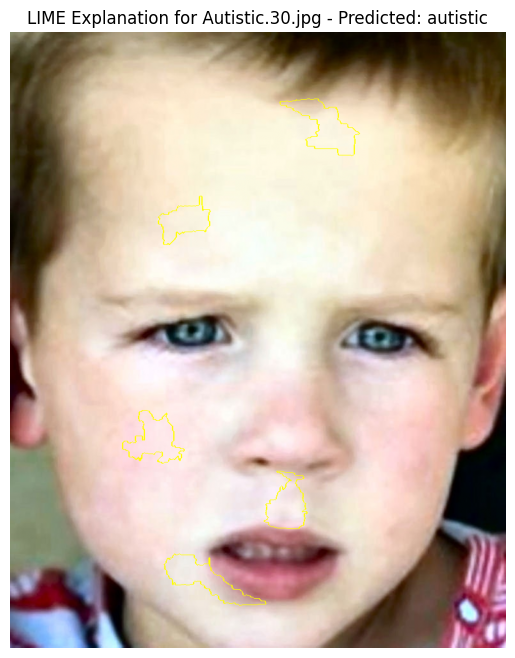

  0%|          | 0/1000 [00:00<?, ?it/s]

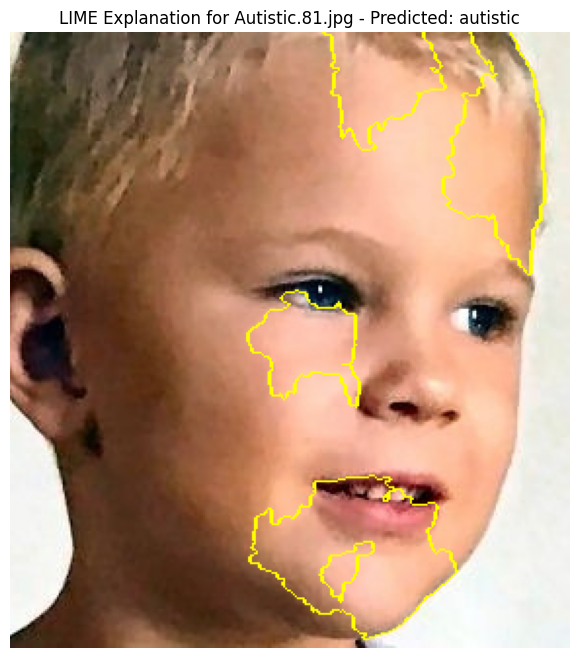

  0%|          | 0/1000 [00:00<?, ?it/s]

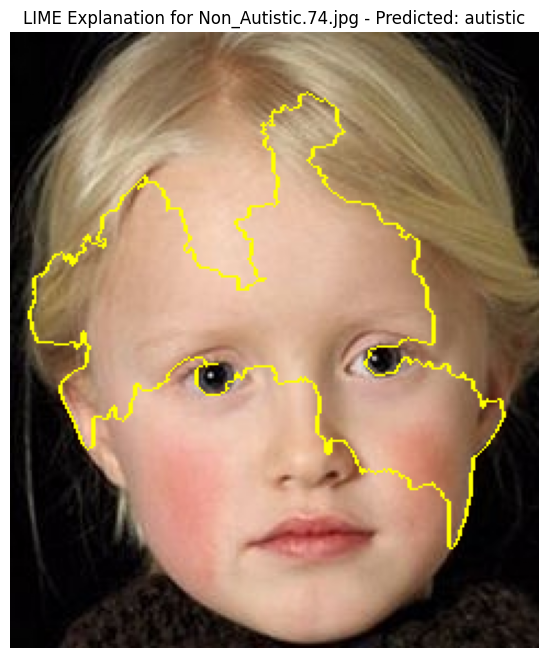

  0%|          | 0/1000 [00:00<?, ?it/s]

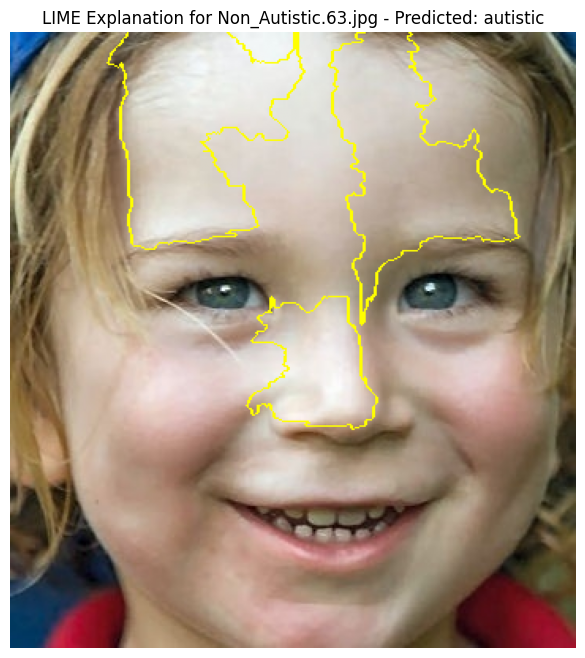

  0%|          | 0/1000 [00:00<?, ?it/s]

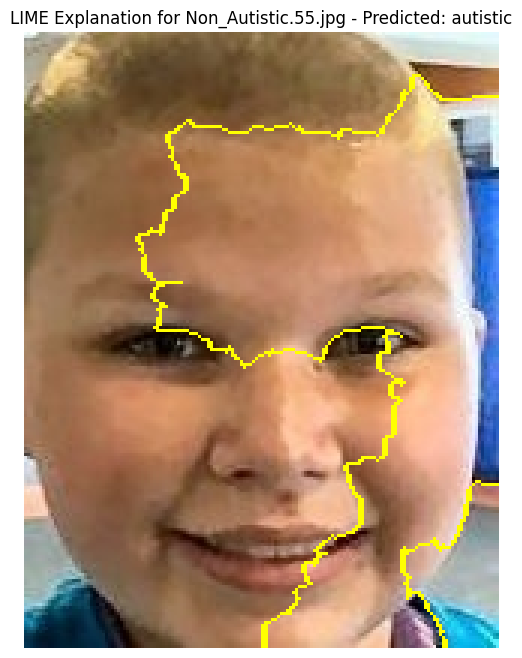

In [11]:
image_dirs = os.path.join(OUTPUT_PATH, "convnext_tiny_lime")
os.makedirs(image_dirs, exist_ok=True)

boundary_dir = os.path.join(image_dirs, "boundary")
os.makedirs(boundary_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(boundary_dir, f"{i}.png"))
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

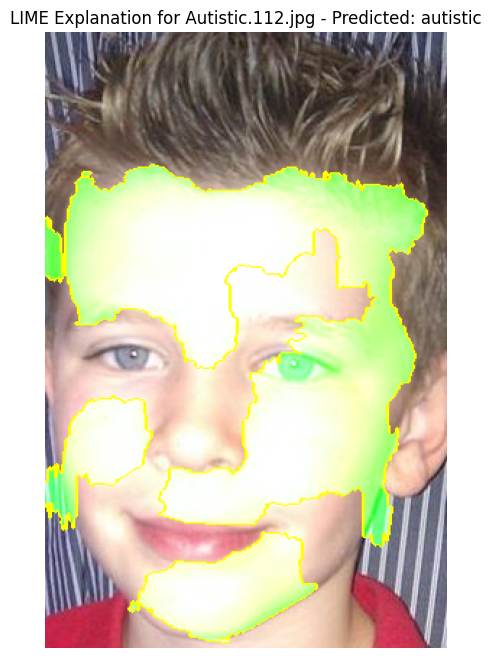

  0%|          | 0/1000 [00:00<?, ?it/s]

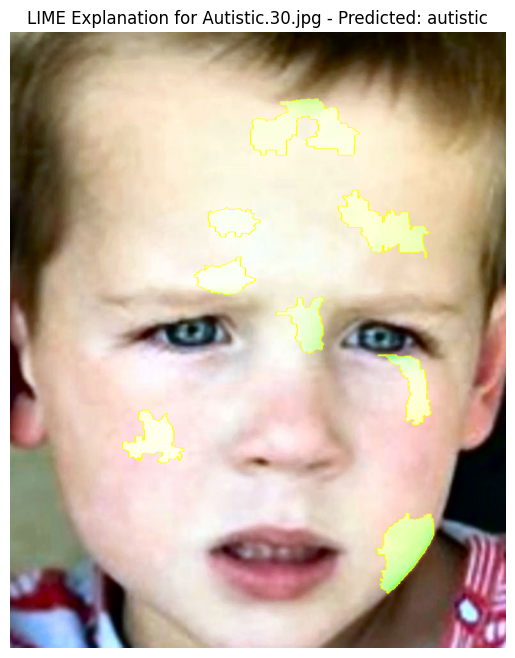

  0%|          | 0/1000 [00:00<?, ?it/s]

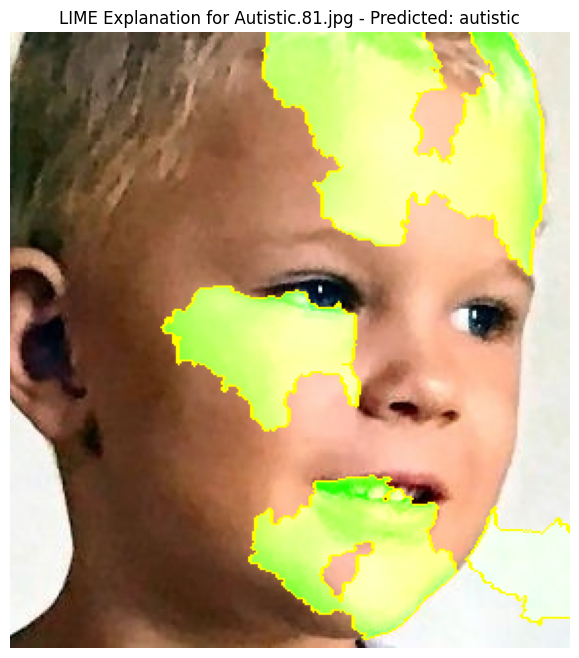

  0%|          | 0/1000 [00:00<?, ?it/s]

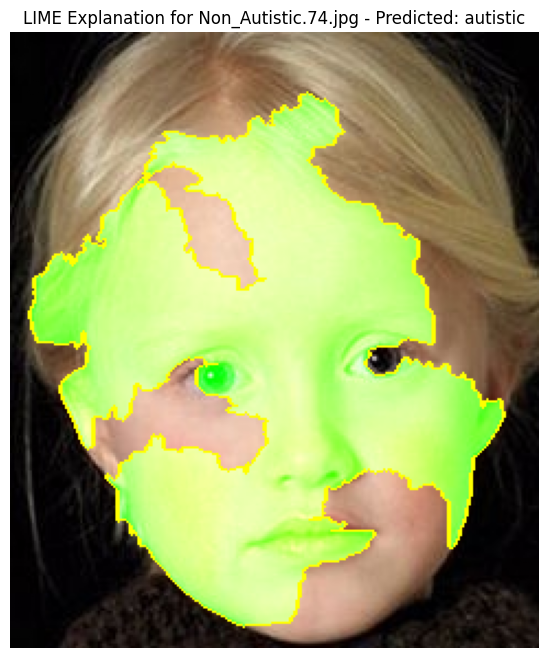

  0%|          | 0/1000 [00:00<?, ?it/s]

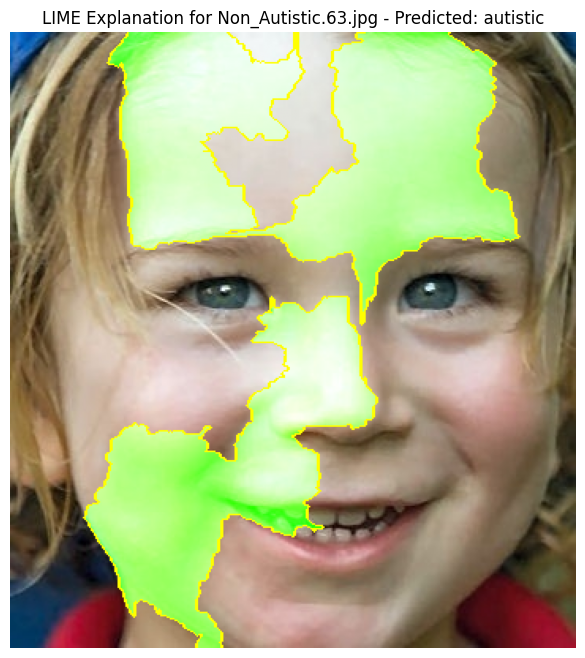

  0%|          | 0/1000 [00:00<?, ?it/s]

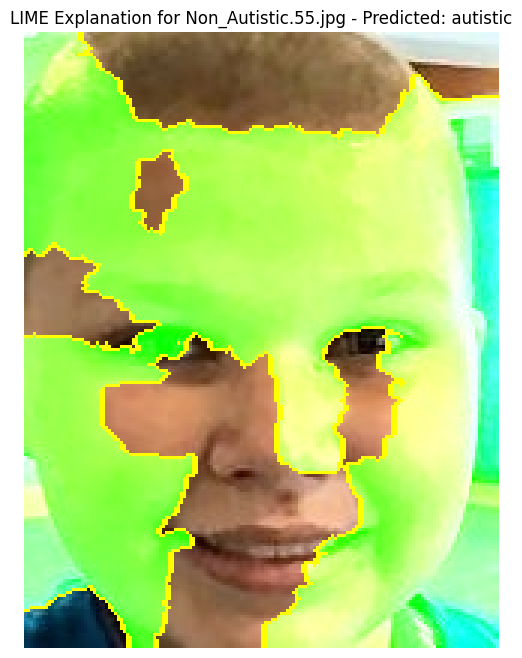

In [12]:
region_dir = os.path.join(image_dirs, "region")
os.makedirs(region_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(region_dir, f"{i}.png"))
    plt.show()

## SHAP Analysis of ConvNext-Tiny on ASD Dataset

In [13]:
!pip install shap

In [14]:
import shap

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Lambda(lambda x: x * (1 / 255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = transforms.Compose(transform)
inv_transform = transforms.Compose(inv_transform)

In [16]:
# Resize + normalize in predict()
def predict(img: np.ndarray) -> torch.Tensor:
    if img.ndim == 4:  # batch
        img = torch.tensor(img).permute(0, 3, 1, 2)  # NHWC -> NCHW
    elif img.ndim == 3:  # single
        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # HWC -> NCHW
    else:
        raise ValueError(f"Unexpected input shape: {img.shape}")

    img = img.float() / 255.0
    img = transforms.Resize((224, 224))(img)
    img = transforms.Normalize(mean=mean, std=std)(img)
    img = img.to(DEVICE)

    with torch.no_grad():
        output = model(img)

    return output

In [17]:
X = []
for img_path in selected_image_paths:
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))  # Resize to consistent size for EfficientNet-B1
    X.append(np.array(img))

X = np.array(X)

print(f"X shape: {X.shape}")

X shape: (6, 224, 224, 3)


In [18]:
topk = 4

batch_size = 50

n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(224, 224)", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=idx2label)

In [19]:
# explain how the input creates the output
shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [01:26<01:03, 21.20s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [02:09<01:00, 30.35s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [02:49<00:33, 33.80s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [03:29<00:00, 35.85s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [04:08, 41.45s/it]


In [20]:
# Invert transform for visualization
shap_values.data = inv_transform(torch.tensor(shap_values.data).float() / 255.0).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

🧠 Image 1: Predicted → autistic


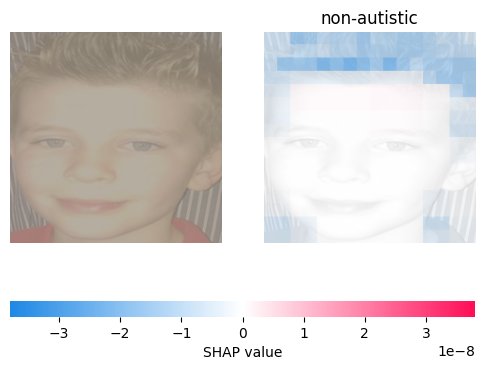

🧠 Image 2: Predicted → autistic


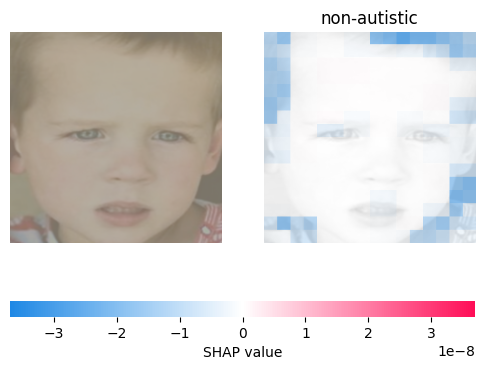

🧠 Image 3: Predicted → autistic


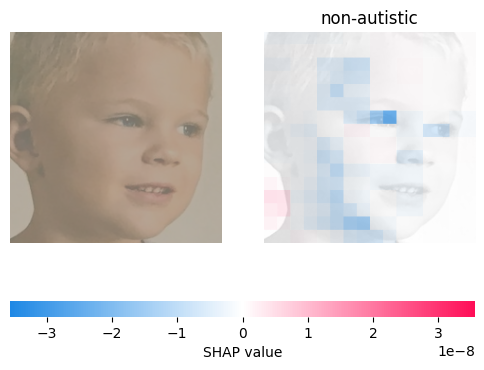

🧠 Image 4: Predicted → autistic


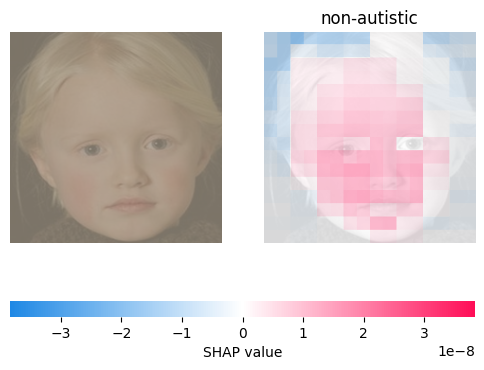

🧠 Image 5: Predicted → autistic


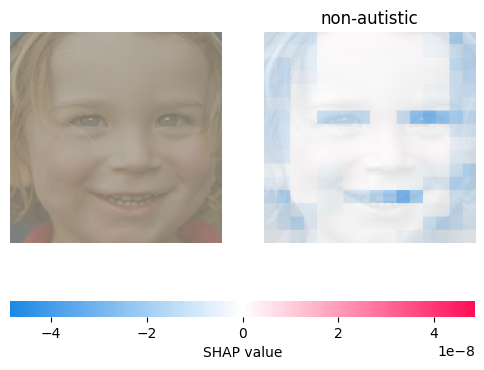

🧠 Image 6: Predicted → autistic


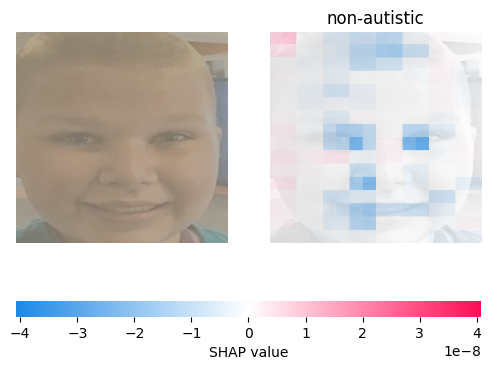

In [21]:

for i in range(len(shap_values.data)):
    # Extract image data
    image_data = shap_values.data[i]

    # SHAP values for each class (each is [num_images, H, W, 3])
    shap_class_0 = shap_values.values[0][i]  # for non-autistic
    shap_class_1 = shap_values.values[1][i]  # for autistic

    # Convert to correct format for plotting
    shap_to_plot = np.stack([shap_class_0, shap_class_1])  # shape [2, H, W, 3]
    image_to_plot = np.expand_dims(image_data, axis=0)     # shape [1, H, W, 3]

    # Optional: Model prediction
    with torch.no_grad():
        img_tensor = torch.tensor(image_data).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
        preds = model(img_tensor)
        predicted_class = torch.argmax(preds, dim=1).item()
        predicted_label = idx2label[predicted_class]

    print(f"🧠 Image {i+1}: Predicted → {predicted_label}")

    # --- SHAP plot ---
    shap.image_plot(
        shap_values=[shap_to_plot],   # must be list of arrays
        pixel_values=image_to_plot,   # also list of arrays
        labels=[idx2label]
    )